/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


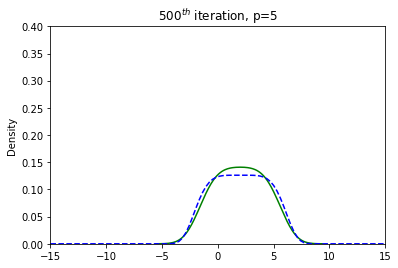

In [ ]:
import math
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

class SVGD_model():

    def __init__(self):
        pass

    def SVGD_kernal(self, x, h=-1):
        init_dist = pdist(x)
        pairwise_dists = squareform(init_dist)
        if h < 0:  # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = h ** 2 / np.log(x.shape[0] + 1)

        kernal_xj_xi = np.exp(- pairwise_dists ** 2 / h)/ (np.sqrt( np.pi * h))
        d_kernal_xi = np.zeros(x.shape)
        for i_index in range(x.shape[0]):
            d_kernal_xi[i_index] = np.matmul(kernal_xj_xi[i_index], x[i_index] - x) * 2 / (np.sqrt( np.pi * h)*h)

        return kernal_xj_xi, d_kernal_xi

    def update(self, x0, lnprob,probdensity,beta=-0.5,alpha=0.1, n_iter=1000, stepsize=1e-3, bandwidth=-1, debug=False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        x = np.copy(x0)

        # adagrad with momentum
        eps_factor = 1e-8
        historical_grad_square = 0
        for iter in range(n_iter):
            if debug and (iter + 1) % 1000 == 0:
                print('iter ' + str(iter + 1))

            kernal_xj_xi, d_kernal_xi = self.SVGD_kernal(x, bandwidth)
            current_grad = (np.matmul(kernal_xj_xi, lnprob(x)) + d_kernal_xi) / x.shape[0]
            #if iter == 0:
            #   historical_grad_square += current_grad ** 2
            #else:
            #    historical_grad_square = alpha * historical_grad_square + (1 - alpha) * (current_grad ** 2)
            adj_grad = current_grad
            x += stepsize * adj_grad

        return x



sns.set_palette('deep', desat=.6)
sns.set_context(rc={'figure.figsize': (8, 5) } )

class OneDimensionGM():

    def __init__(self, omega, mean, var, p):
        self.omega = omega
        self.mean = mean
        self.var = var
        self.p = p

    def dlnprob(self, x):
        rep_x = np.matlib.repmat(x, 1, self.omega.shape[0])
        category_prob = np.exp(- (abs(rep_x - self.mean)/self.var) ** self.p) / (2*(self.var/self.p)*math.gamma(1/self.p))*self.omega
        den = np.sum(category_prob, 1)
        num = (- (self.p/self.var)*((rep_x - self.mean) / self.var)*(abs(rep_x - self.mean) / self.var)**(self.p-2) * category_prob).sum(1)
        return np.expand_dims((num / den), 1)

    def MGprob(self, x):
        rep_x = np.matlib.repmat(x, 1, self.omega.shape[0])
        category_prob = np.exp(- (abs(rep_x - self.mean)/self.var) ** self.p) / (2*(self.var/self.p)*math.gamma(1/self.p)) * self.omega
        den = np.sum(category_prob, 1)
        return np.expand_dims(den, 1)

if __name__ == "__main__":

    w = np.array([1])
    mean = np.array([2])
    p = np.array([5])
    sigma = 3
    var = np.array([sigma*math.sqrt(math.gamma(1./p))/math.gamma(3./p)])
    int_p = int(p)
    OneDimensionGM_model = OneDimensionGM(w, mean, var,p)

    np.random.seed(0)

    x0 = np.random.normal(-10, 1, [250, 1]);
    dlnprob = OneDimensionGM_model.dlnprob
    probdensity=OneDimensionGM_model.MGprob

    svgd_model = SVGD_model()
    n_iter = 500
    beta=0
    x = svgd_model.update(x0, dlnprob, probdensity, beta=beta, alpha=0.1, n_iter=n_iter, stepsize=1, bandwidth=1, debug=True)


    #plot result
    sns.kdeplot(x.reshape((250,)), bw = .4, color = 'g')

    mg_prob = OneDimensionGM_model.MGprob
    x_lin = np.expand_dims(np.linspace(-15, 15, 100), 1)
    x_prob = mg_prob(x_lin)
    plt.plot(x_lin, x_prob, 'b--')
    plt.axis([-15, 15, 0, 0.4])
    plt.title(str(n_iter) + '$ ^{th}$ iteration, '+'p='+str(int_p))
    plt.show()


